# Crime_Project
* Observations and Trends at State Level
* Observations and Trends at Chicago

### Dependencies and Setup

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
sns.set()

pd.set_option('display.max_colwidth', 30)
pd.options.display.float_format = '{:,.2f}'.format

### Import DataSets for Analysis
* states_total.csv (generated by api request: census_states.ipynb, source of data: census.org)
* uscities_data.csv (source: census.org, xlsx file)
* state_crime

In [2]:
filter_columns = ['State_Name', 'Year', 'Population', 'House_Income', 'Per_Cap_Income', 'Pov_Rate','Unemp_Rate','Geo','Lat','Lng']
states_econ = pd.read_csv('resources/states_total.csv').filter(filter_columns)
states_econ = states_econ[(states_econ['Year'] == 2011) | (states_econ['Year'] == 2012)].filter(filter_columns)
states_econ

,State_Name,Year,Population,House_Income,Per_Cap_Income,Pov_Rate,Unemp_Rate,Geo,Lat,Lng
0,Alabama,2011,"4,747,424.00","42,934.00","23,483.00",17.13,4.54,South,32.78,-86.83
1,Alaska,2011,"700,703.00","69,014.00","31,944.00",9.29,4.41,North,64.07,-152.28
2,Arizona,2011,"6,337,373.00","50,752.00","25,784.00",15.84,4.23,South,34.27,-111.66
3,Arkansas,2011,"2,895,928.00","40,149.00","21,833.00",17.85,3.94,South,34.89,-92.44
4,California,2011,"36,969,200.00","61,632.00","29,634.00",14.10,5.06,South,37.18,-119.47
...,...,...,...,...,...,...,...,...,...,...
97,Virginia,2012,"8,014,955.00","63,636.00","33,326.00",10.72,3.58,South,37.52,-78.85
98,Washington,2012,"6,738,714.00","59,374.00","30,661.00",12.67,4.59,South,47.38,-120.45
99,West Virginia,2012,"1,850,481.00","40,400.00","22,482.00",17.11,3.52,South,38.64,-80.62
100,Wisconsin,2012,"5,687,219.00","52,627.00","27,426.00",12.15,4.05,North,44.62,-89.99


In [3]:
filter_columns = ['State', 'Year', 'Data.Totals.Property.All', 'Data.Totals.Violent.All']
states_crime = pd.read_csv('resources/state_crime.csv')
states_crime = states_crime[(states_crime['Year'] == 2011) | (states_crime['Year'] == 2012)].filter(filter_columns)
states_crime = states_crime.rename(columns={
                    'State': 'State_Name',
                    'Data.Totals.Property.All': 'Crime_Prop',
                    'Data.Totals.Violent.All':'Crime_Viol'})
states_crime[['Crime_Prop', 'Crime_Viol']] = states_crime[['Crime_Prop', 'Crime_Viol']].astype(float)
states_data = pd.merge(states_econ, states_crime, how='inner')
states_data['Crime_Tot'] = states_data['Crime_Prop'] + states_data['Crime_Viol']
states_data['Crime_Adj'] = states_data['Crime_Tot']/states_data['Population']*100000
states_data_2011 = states_data[states_data['Year']==2011]
states_data_2011.to_csv("resources/states_2011.csv", encoding="utf-8", index=False)
states_data

,State_Name,Year,Population,House_Income,Per_Cap_Income,Pov_Rate,Unemp_Rate,Geo,Lat,Lng,Crime_Prop,Crime_Viol,Crime_Tot,Crime_Adj
0,Alabama,2011,"4,747,424.00","42,934.00","23,483.00",17.13,4.54,South,32.78,-86.83,"173,192.00","20,166.00","193,358.00","4,072.90"
1,Alaska,2011,"700,703.00","69,014.00","31,944.00",9.29,4.41,North,64.07,-152.28,"19,094.00","4,416.00","23,510.00","3,355.20"
2,Arizona,2011,"6,337,373.00","50,752.00","25,784.00",15.84,4.23,South,34.27,-111.66,"229,896.00","26,789.00","256,685.00","4,050.34"
3,Arkansas,2011,"2,895,928.00","40,149.00","21,833.00",17.85,3.94,South,34.89,-92.44,"110,430.00","14,173.00","124,603.00","4,302.70"
4,California,2011,"36,969,200.00","61,632.00","29,634.00",14.10,5.06,South,37.18,-119.47,"973,822.00","154,943.00","1,128,765.00","3,053.26"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Virginia,2012,"8,014,955.00","63,636.00","33,326.00",10.72,3.58,South,37.52,-78.85,"176,985.00","15,564.00","192,549.00","2,402.37"
98,Washington,2012,"6,738,714.00","59,374.00","30,661.00",12.67,4.59,South,47.38,-120.45,"252,333.00","20,386.00","272,719.00","4,047.05"
99,West Virginia,2012,"1,850,481.00","40,400.00","22,482.00",17.11,3.52,South,38.64,-80.62,"43,878.00","5,869.00","49,747.00","2,688.33"
100,Wisconsin,2012,"5,687,219.00","52,627.00","27,426.00",12.15,4.05,North,44.62,-89.99,"140,513.00","16,064.00","156,577.00","2,753.14"


## Data Exploration
* 2011

In [4]:
# Extracting Data for 2011
expl_data_2011 = states_data[states_data['Year']==2011].filter(['Geo', 'Lat', 'Pov_Rate', 'Unemp_Rate', 'House_Income', 'Crime_Adj'])

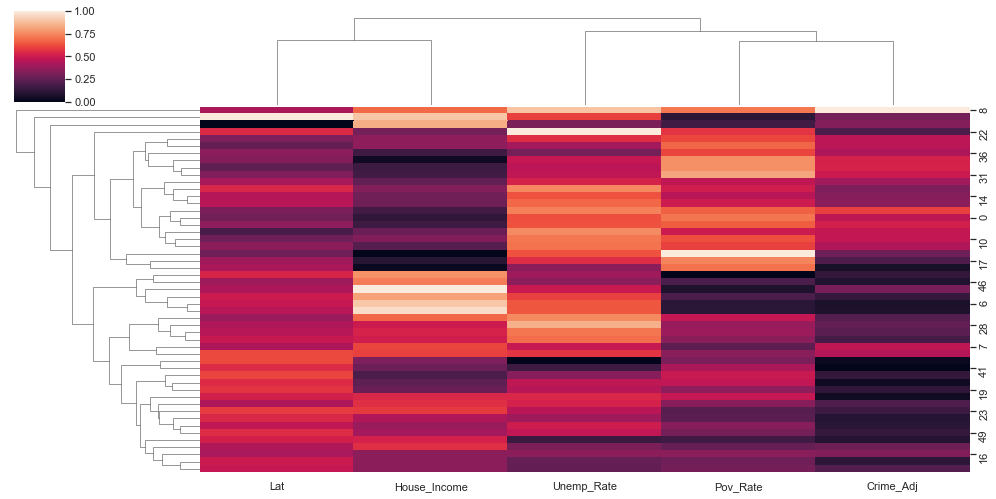

In [5]:
# Plot a hierarchically clustered heatmap
cluster_data = expl_data_2011.filter(['Pov_Rate', 'Lat', 'Unemp_Rate', 'House_Income', 'Crime_Adj'])
g = sns.clustermap(cluster_data, figsize=(14, 7), standard_scale=1)
plt.savefig('../images/dendrogram_2011.png')

In [6]:
# Correlation Matrix
corr = expl_data_2011.corr()
print('Correlation Matrix, State Level, 2011')
corr.style.background_gradient(cmap='coolwarm')

Correlation Matrix, State Level, 2011


,Lat,Pov_Rate,Unemp_Rate,House_Income,Crime_Adj
Lat,1.000000,-0.451498,-0.107131,0.261922,-0.452675
Pov_Rate,-0.451498,1.000000,0.295770,-0.797120,0.524317
Unemp_Rate,-0.107131,0.295770,1.000000,0.057184,0.427287
House_Income,0.261922,-0.797120,0.057184,1.000000,-0.191683
Crime_Adj,-0.452675,0.524317,0.427287,-0.191683,1.000000


                        Data exploration for 2011 year (Northern vs Southern States)


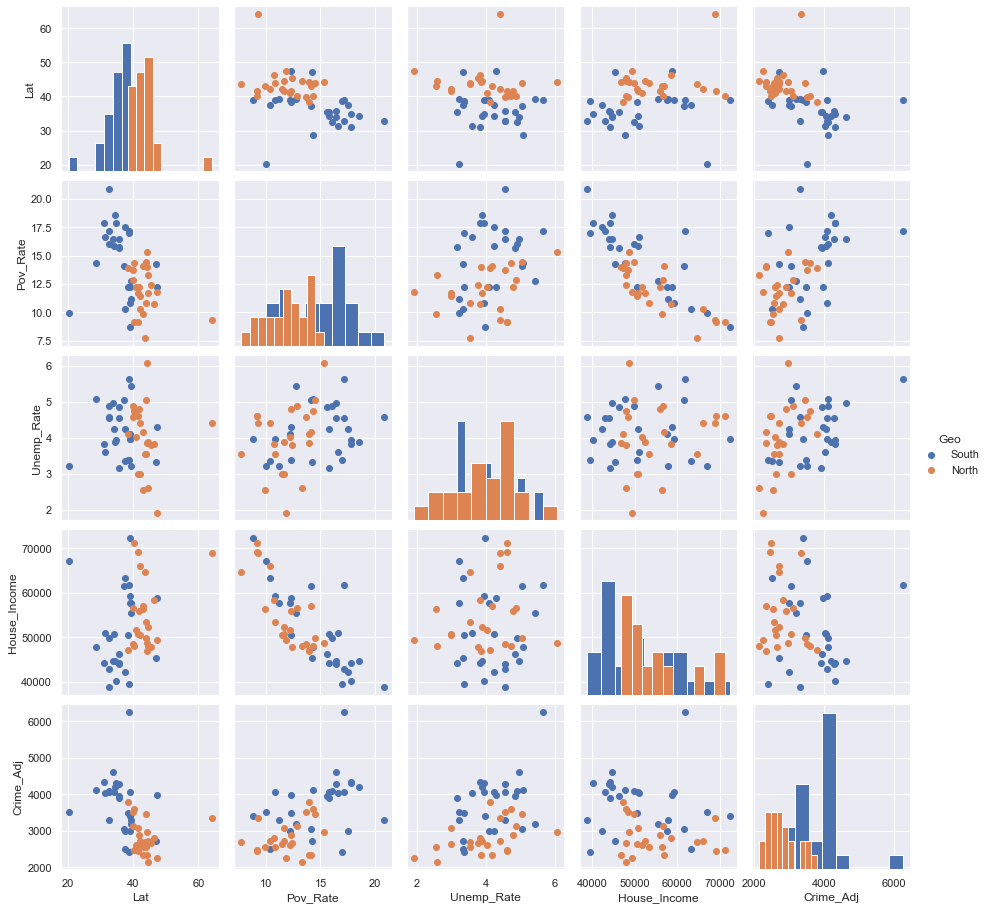

In [7]:
# Data Exploration for 2011
g=sns.PairGrid(expl_data_2011, hue='Geo')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()
print(' '*23,'Data exploration for 2011 year (Northern vs Southern States)')
plt.savefig('images/exploration_2011.png')